### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Bidirectional, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re


### Load Data

In [3]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [10]:
df = pd.read_csv("D:/Setiment_analysis/data/data_comment_headphone.csv")
df.drop(["name_guest", "date_review", "overview_text"],axis=1, inplace= True)
df.dropna(inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20543 entries, 0 to 20599
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   overview_rating  20543 non-null  object
 1   comment          20543 non-null  object
dtypes: object(2)
memory usage: 481.5+ KB


### Data proprecessing

In [11]:
df['overview_rating'] = df['overview_rating'].str.extract(r'(\d+\.\d+)').astype(float)


In [12]:

def annotation(rating):
    if(rating == 1.0 or rating == 2.0):
        return "negative"
    elif(rating == 3.0):
        return "neutral"
    else:
        return "positive" 

df["overview_rating"] = df["overview_rating"].apply(annotation)

In [13]:
df["overview_rating"].value_counts(normalize= True)

overview_rating
positive    0.537361
negative    0.307161
neutral     0.155479
Name: proportion, dtype: float64

c:\Users\ducth\anaconda3\envs\iot\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

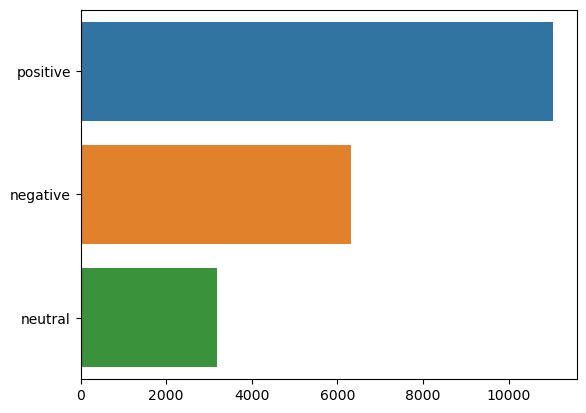

In [28]:
x = df["overview_rating"].value_counts()
x = x.to_numpy()
y = ["positive", "negative", "neutral"]
sns.barplot(x=x, y=y)

In [15]:
x

overview_rating
positive    11039
negative     6310
neutral      3194
Name: count, dtype: int64

In [10]:
l = []
for i in df['overview_rating']:
  if i == 'negative':
    l.append(0)
  elif i == 'neutral':
    l.append(1)
  else:
    l.append(2)

### Natural Language Proprecessing 

In [11]:
df1 = df.copy()

* Standardize words

In [12]:
def remove_punctuation(text):
    cleaned_text = re.sub(r'\.\s*$', '', text)  # Loại bỏ dấu chấm ở cuối câu
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)  # Loại bỏ dấu câu và ký tự đặc biệt
    return cleaned_text

df1["comment"] = df1["comment"].str.lower()
df1["comment"] = df1["comment"].apply(remove_punctuation)
df1["comment"][1]

'i bought these in early january and for a while they were great theyre comfortable and they had good sound quality unfortunately they started having problems about two weeks ago and now they hardly have any sound at all and when they do it is really tinny'

* Stopword

In [13]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(comment):
    words = comment.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Thực hiện loại bỏ stopwords từ cột 'comment'
df1['comment'] = df1['comment'].apply(remove_stopwords)


In [14]:
print(list(stop_words))

['am', 'has', 'there', 'now', 'at', 'but', 'yourselves', 'what', 'not', 'those', 'so', 'ain', 'on', 'over', 'needn', 'aren', 'being', 'hadn', 'through', 'be', 'don', 'very', 'wasn', 'as', 'into', 'just', "weren't", "it's", 'are', 'about', "won't", 'both', 'any', 'themselves', 'himself', "you'll", "haven't", 'my', 'after', 'they', "you're", "that'll", 'she', 'how', 'herself', 'them', 'under', 'no', 'you', 'by', 'a', 'its', 'some', 'me', 'mustn', 'ma', 'the', 'to', 'all', 'an', 'once', 'will', 'y', 'off', 'nor', 'who', 've', 'where', 'yours', 'd', "wasn't", 'we', "hasn't", 'each', 'theirs', 'until', 'if', 'their', 'does', 'further', 'shan', 'itself', "needn't", 'other', 'ours', 'had', 'during', 'from', 'because', 'm', 'when', 'did', 'haven', 'o', 'should', 'or', 'against', 'between', 'while', 'were', 's', "she's", "didn't", "shouldn't", "should've", 'it', 'have', 'that', 'whom', "couldn't", "mightn't", "wouldn't", "hadn't", 'such', "you've", 'shouldn', 'having', 'didn', 'been', 're', "is

* Stemming

In [15]:
# Khởi tạo đối tượng PorterStemmer
stemmer = PorterStemmer()
# Hàm để thực hiện stemming trên một đoạn văn bản
def stem_text(text):
    # Sử dụng word_tokenize để tách văn bản thành các từ
    words = word_tokenize(text)
    # Thực hiện stemming cho mỗi từ
    stemmed_words = [stemmer.stem(word) for word in words]
    # Ghép lại các từ đã được stemming thành một chuỗi văn bản
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text
df1['comment'] = df1['comment'].apply(stem_text)

* Lemmatization

In [16]:
# # Khởi tạo WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

# # Hàm để lấy phần loại từ của WordNet
# def get_wordnet_pos(word):
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}
#     return tag_dict.get(tag, wordnet.NOUN)

# # Hàm để thực hiện lemmatization trên một câu
# def lemmatize_text(text):
#     words = nltk.word_tokenize(text)
#     lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
#     return ' '.join(lemmatized_words)
# df1['comment'] = df1['comment'].apply(lemmatize_text)


In [17]:
X = df1["comment"]
Y = np.array(l)

* Tokenization

In [2]:
vocab_size = 200000
embedding_dim = 32
max_length = 1800

In [19]:
tokenizer = Tokenizer(num_words= vocab_size, oov_token= "<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

In [20]:
X_padded = pad_sequences(X_sequences, maxlen=max_length, truncating= "post", padding= "post")

In [21]:
X_padded.shape

(20545, 1800)

In [22]:
X_padded

array([[ 240,  142,  238, ...,    0,    0,    0],
       [  35, 1499, 1522, ...,    0,    0,    0],
       [3235,   10,    5, ...,    0,    0,    0],
       ...,
       [  56,  333,   71, ...,    0,    0,    0],
       [ 173,  329,    4, ...,    0,    0,    0],
       [  25,  281,    3, ...,    0,    0,    0]])

### Train/Test Split

In [23]:
label_encode = OneHotEncoder(sparse= False, categories= 'auto')
Y_target = label_encode.fit_transform(Y.reshape(-1, 1))
Y_target.shape

d:\Users\admin\App\Local\Program\conda\envs\thuan\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(20545, 3)

In [24]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((X_padded, Y_target))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(512)
dataset = dataset.prefetch(8) # helps bottlenecks

In [25]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### BiLSTM Model

In [14]:
model = Sequential([
    Embedding(input_dim= vocab_size, output_dim= embedding_dim, input_length= max_length, input_shape= (1800,)),
    Bidirectional(LSTM(embedding_dim, activation='tanh')),
    Dense(128, activation= "relu"),
    Dense(256, activation= "relu"),
    Dense(128, activation= "relu"),
    Dense(3, activation= "softmax")
])

model.compile(loss= CategoricalCrossentropy(),
              optimizer= Adam(learning_rate= 0.001),
              metrics= ["accuracy"])

c:\Users\ducth\anaconda3\envs\iot\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\ducth\anaconda3\envs\iot\Lib\site-packages\keras\src\layers\core\embedding.py:89: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 1800, 32)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,267 (24.76 MB)

 Trainable params: 6,491,267 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
def plot_training_history(history):
    # Lấy các thông tin về mất mát và độ chính xác từ lịch sử huấn luyện
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    # Vẽ biểu đồ mất mát
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Vẽ biểu đồ độ chính xác
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


Epoch 1/50


28/28 [==============================] - 8s 182ms/step - loss: 1.0030 - accuracy: 0.5301 - val_loss: 0.9552 - val_accuracy: 0.5378
Epoch 2/50
28/28 [==============================] - 5s 165ms/step - loss: 0.8595 - accuracy: 0.6170 - val_loss: 0.6950 - val_accuracy: 0.7275
Epoch 3/50
28/28 [==============================] - 5s 162ms/step - loss: 0.6538 - accuracy: 0.7361 - val_loss: 0.6289 - val_accuracy: 0.7488
Epoch 4/50
28/28 [==============================] - 5s 165ms/step - loss: 0.5893 - accuracy: 0.7645 - val_loss: 0.5684 - val_accuracy: 0.7688
Epoch 5/50
28/28 [==============================] - 5s 165ms/step - loss: 0.5502 - accuracy: 0.7760 - val_loss: 0.5300 - val_accuracy: 0.7854
Epoch 6/50
28/28 [==============================] - 5s 164ms/step - loss: 0.5167 - accuracy: 0.7903 - val_loss: 0.4820 - val_accuracy: 0.8010
Epoch 7/50
28/28 [==============================] - 5s 164ms/step - loss: 0.4818 - accuracy: 0.8075 - val_loss: 0.4480 - val_accuracy: 0.8281
Epoch 8/50
28/28 

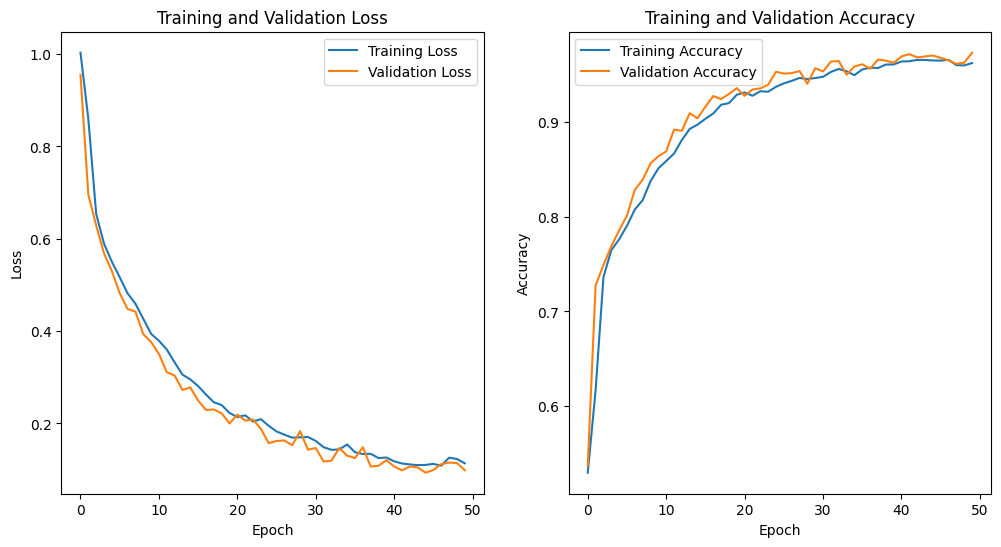

In [29]:
import time
start = time.time()
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train, epochs= 50 , validation_data= val, verbose= 1)

end = time.time()
execution_time = end - start
print("==============================")
print("execution_time: ", execution_time)
print("==============================")
plot_training_history(history)

### Evaluate Model 

In [30]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch

In [31]:
y_pred = model.predict(X_true)
y_pred

16/16 [==============================] - 1s 30ms/step


array([[9.9406999e-01, 4.8890235e-03, 1.0409630e-03],
       [1.9256030e-08, 1.6115151e-06, 9.9999833e-01],
       [9.9731487e-01, 1.5986045e-03, 1.0865612e-03],
       ...,
       [5.5499971e-05, 5.5142929e-04, 9.9939311e-01],
       [7.6764190e-06, 1.3956073e-04, 9.9985278e-01],
       [2.5018007e-01, 3.4620312e-01, 4.0361685e-01]], dtype=float32)

In [32]:
y_true = np.argmax(y_true, axis= 1)

In [33]:
y_pred = np.argmax(y_pred, axis= 1)

In [34]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       163
           1       0.96      0.88      0.92       101
           2       0.95      0.98      0.96       248

    accuracy                           0.96       512
   macro avg       0.96      0.94      0.95       512
weighted avg       0.96      0.96      0.95       512



### Results

In [35]:
# Create a DataFrame
df3 = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y_true  512 non-null    int64
 1   y_pred  512 non-null    int64
dtypes: int64(2)
memory usage: 8.1 KB


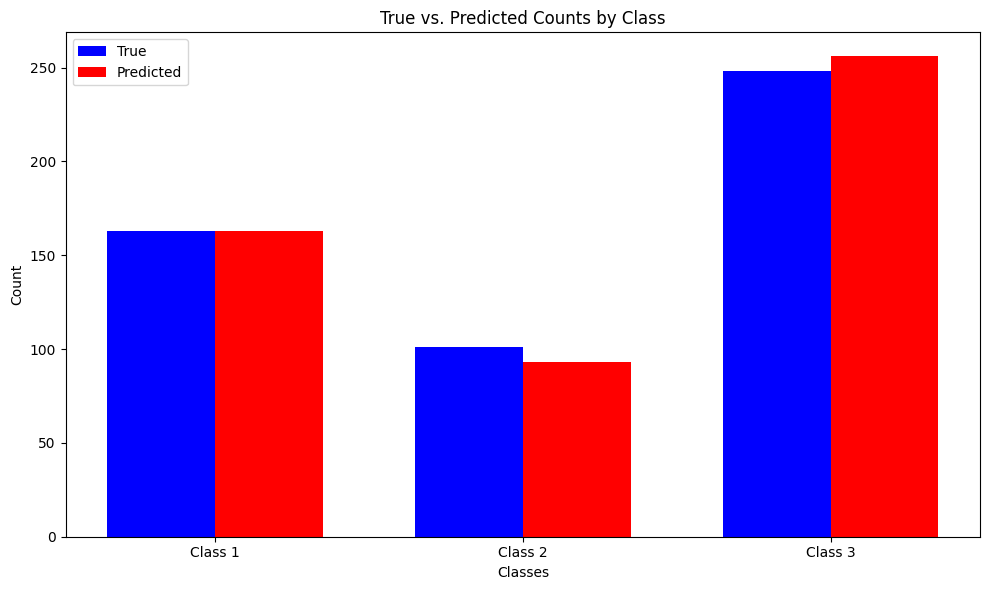

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Assume y_true và y_pred là các mảng chứa dữ liệu thực tế và dữ liệu dự đoán tương ứng
# Đảm bảo rằng độ dài của y_true và y_pred là như nhau

# Tạo mảng các lớp
classes = ['Class 1', 'Class 2', 'Class 3']

# Đếm số lượng dữ liệu cho từng lớp trong y_true và y_pred
true_counts = [np.sum(y_true == i) for i in range(len(classes))]
pred_counts = [np.sum(y_pred == i) for i in range(len(classes))]

# Tạo index cho các lớp
index = np.arange(len(classes))

# Độ rộng của cột
bar_width = 0.35

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(index, true_counts, bar_width, label='True', color='b')
plt.bar(index + bar_width, pred_counts, bar_width, label='Predicted', color='r')

# Gắn nhãn và tiêu đề
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('True vs. Predicted Counts by Class')
plt.xticks(index + bar_width / 2, classes)
plt.legend()
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()
